In [1]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import pandas as pd
from scaling.utils import (
    get_pareto_frontier, 
    get_final_points_from_curve_set, 
    fit_linear_model,
    functional_form_chin3,
    fit_parametric_form,
    fit_parametric_form_stable,
    functional_form_chin3_stable,
)
from scaling.visualize import visualize_train_curves, plot_line_fit, plot_isoflops

In [2]:
mlp_df = pd.read_parquet(
    "../data/mlp_results.parquet",
)
# warmstarting_df = preprocess_warmstarting(warmstarting_df)
display(mlp_df)

,source,scaling,tkpm_group,scale_id,base_scale,target_scale,base_name,base_layers,base_n_embd,base_params_m,...,cfg_tokens_per_param,cfg_target_tokens_per_param,cfg_warmup_fraction,cfg_cooldown_fraction,x_col,curve_flops,curve_step,curve_tkpp,curve_train,curve_val
0,grid_search,depth,20.0,s0,NaN,0,None,NaN,NaN,NaN,...,20.0,20.0,0.01,0.0,flops,"[456228860.0, 912457700.0, 1368686600.0, 18249...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0008618832, 0.0017237664, 0.0025856497, 0.0...","[1.043893, 0.8427927, 1.0008659, 1.1242492, 1....","[1.0503591, nan, nan, nan, nan, nan, nan, nan,..."
1,grid_search,depth,20.0,s0,NaN,0,None,NaN,NaN,NaN,...,20.0,20.0,0.01,0.0,flops,"[456228860.0, 912457700.0, 1368686600.0, 18249...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0008618832, 0.0017237664, 0.0025856497, 0.0...","[1.043893, 0.8427927, 1.0008659, 1.1242492, 1....","[1.0503591, nan, nan, nan, nan, nan, nan, nan,..."
2,grid_search,depth,20.0,s0,NaN,0,None,NaN,NaN,NaN,...,20.0,20.0,0.01,0.0,flops,"[456228860.0, 912457700.0, 1368686600.0, 18249...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0008618832, 0.0017237664, 0.0025856497, 0.0...","[1.043893, 0.8427927, 1.0008501, 1.1241761, 1....","[1.0503591, nan, nan, nan, nan, nan, nan, nan,..."
3,grid_search,depth,20.0,s0,NaN,0,None,NaN,NaN,NaN,...,20.0,20.0,0.01,0.2,flops,"[456228860.0, 912457700.0, 1368686600.0, 18249...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0008618832, 0.0017237664, 0.0025856497, 0.0...","[1.043893, 0.8427927, 1.000802, 1.1239564, 1.1...","[1.0503591, nan, nan, nan, nan, nan, nan, nan,..."
4,grid_search,depth,20.0,s0,NaN,0,None,NaN,NaN,NaN,...,20.0,20.0,0.01,0.2,flops,"[456228860.0, 912457700.0, 1368686600.0, 18249...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0008618832, 0.0017237664, 0.0025856497, 0.0...","[1.043893, 0.8427927, 1.000802, 1.1239564, 1.1...","[1.0503591, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,grid_search,width,50.0,s5,NaN,5,None,NaN,NaN,NaN,...,50.0,50.0,0.01,0.2,flops,"[6501021000.0, 13002042000.0, 19503065000.0, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0003422979, 0.0006845958, 0.0010268937, 0.0...","[0.9674903, 1.0583065, 1.1304526, 0.9964859, 1...","[1.0506552, nan, nan, nan, nan, nan, nan, nan,..."
2628,grid_search,width,50.0,s5,NaN,5,None,NaN,NaN,NaN,...,50.0,50.0,0.05,0.0,flops,"[6501021000.0, 13002042000.0, 19503065000.0, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0003422979, 0.0006845958, 0.0010268937, 0.0...","[0.9674903, 1.0583065, 1.130453, 0.9964872, 1....","[1.0506552, nan, nan, nan, nan, nan, nan, nan,..."
2629,grid_search,width,50.0,s5,NaN,5,None,NaN,NaN,NaN,...,50.0,50.0,0.05,0.2,flops,"[6501021000.0, 13002042000.0, 19503065000.0, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0003422979, 0.0006845958, 0.0010268937, 0.0...","[0.9674903, 1.0583065, 1.130453, 0.9964872, 1....","[1.0506552, nan, nan, nan, nan, nan, nan, nan,..."
2630,grid_search,width,50.0,s5,NaN,5,None,NaN,NaN,NaN,...,50.0,50.0,0.10,0.0,flops,"[6501021000.0, 13002042000.0, 19503065000.0, 2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0003422979, 0.0006845958, 0.0010268937, 0.0...","[0.9674903, 1.0583065, 1.130453, 0.9964873, 1....","[1.0506552, nan, nan, nan, nan, nan, nan, nan,..."


In [3]:
mlp_df['method'].unique()

array(['scratch', 'snp', 'stacking', 'net2net'], dtype=object)

In [4]:
width_scale_to_params = {
    0: 0.1e6,
    1: 0.1e6,
    2: 0.2e6,
    3: 0.4e6,
    4: 0.9e6,
    5: 1.8e6,
    6: 3.5e6,
    7: 7.0e6,
    8: 14.2e6,
    9: 25.2e6,
    10: 100.7e6,
}
width_scale_to_hidden_dim = {
    0: 48,
    1: 68,
    2: 96,
    3: 136,
    4: 192,
    5: 272,
    6: 384,
    7: 540,
    8: 768,
    9: 1024,
    10: 2048,
}

# create base_N and target_N columns
mlp_df['base_N'] = mlp_df['base_scale'].map(lambda x: width_scale_to_hidden_dim.get(x, np.nan))
mlp_df['target_N'] = mlp_df['target_scale'].map(lambda x: width_scale_to_hidden_dim.get(x, np.nan))
mlp_df['max_flops'] = mlp_df['curve_flops'].map(lambda x: x[-1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

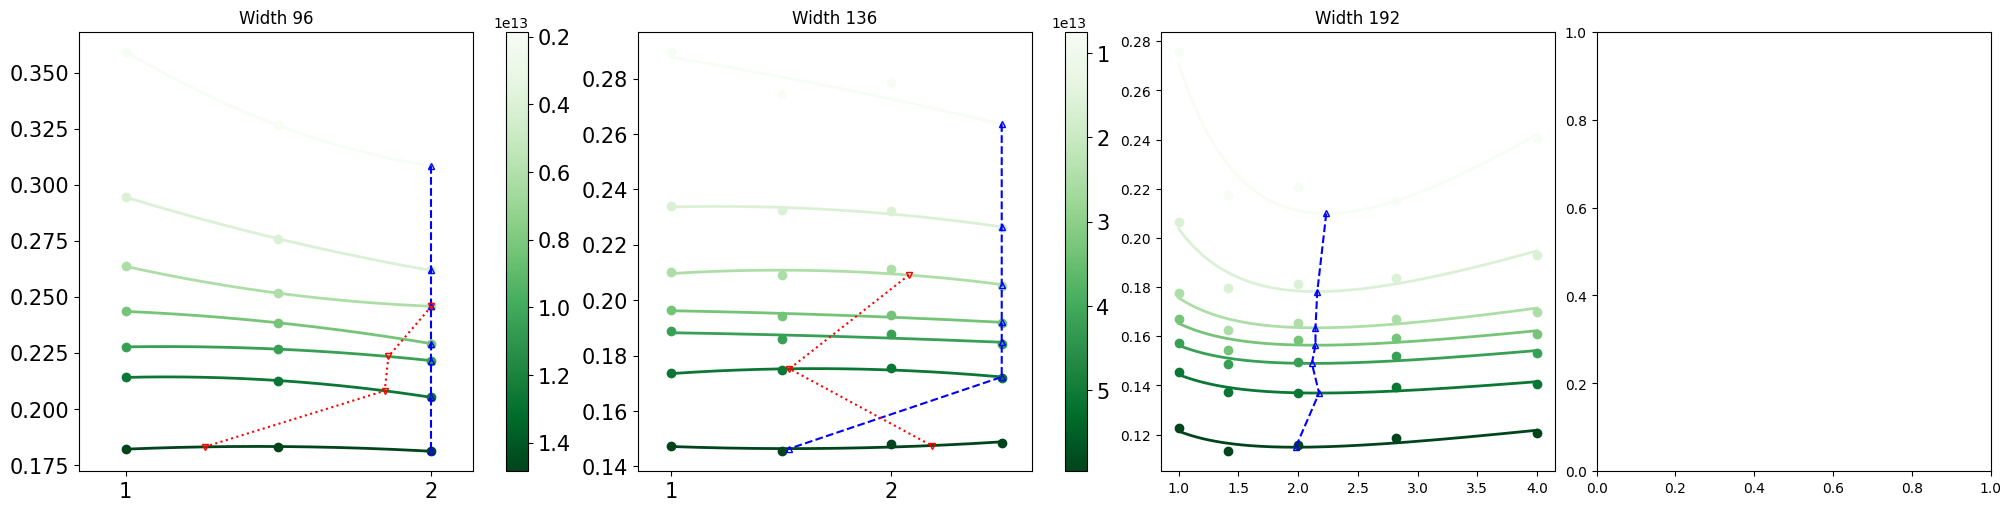

In [15]:
def get_loss_at_flops(df: pd.DataFrame, flop_intervals: list[float]) -> pd.Series:
    """Get the loss at a specific flop value by interpolation."""
    best_learning_curve = None
    best_final_loss = float('inf')
    
    # iterate over rows
    for row in df.itertuples(index=False):
        final_loss = row.curve_train[-1]
        if final_loss < best_final_loss:
            best_final_loss = final_loss
            best_learning_curve = pd.Series(
                data=row.curve_val,
                index=row.curve_flops
            )
    
    # add the flops into the Series if not present
    for flop in flop_intervals:
        if flop not in best_learning_curve.index:
            best_learning_curve.loc[flop] = np.nan
    best_learning_curve = best_learning_curve.sort_index()
    # interpolate nans
    best_learning_curve = best_learning_curve.interpolate(method='linear')
    return best_learning_curve.loc[flop_intervals]



TKPM = 50.
MIN_FLOPS_SCALE_FACTOR = 8
SCALING = "width"
METHOD = "net2net"


mlp_selection_df = mlp_df[mlp_df['tkpm_group']==TKPM]
mlp_selection_df = mlp_selection_df[mlp_selection_df['scaling']==SCALING]

target_models = sorted(mlp_selection_df['target_N'].unique())[-4:]# [-3:-1]
fig, axes = plt.subplots(1, len(target_models), figsize=(5 * len(target_models), 5), layout='constrained');
axes = np.atleast_1d(axes)
for i, target_model in enumerate(target_models):
    target_model_df = mlp_selection_df[mlp_selection_df['target_N']==target_model]
    no_growth_df = target_model_df[target_model_df['method']=='scratch']
    
    # calculate flop intervals
    max_flops = no_growth_df['max_flops'].max()
    min_flops = max_flops / MIN_FLOPS_SCALE_FACTOR
    flop_intervals = np.linspace(min_flops, max_flops, 7)
    flops_df = pd.DataFrame()
    
    # add growth factor == 1
    flops_df[1.] = get_loss_at_flops(no_growth_df, flop_intervals)
    
    # add growth factor > 1
    shrink_target_model_df = target_model_df[target_model_df['method'] == METHOD]
    # check if it is in a shrink list
    
    base_models = sorted(shrink_target_model_df['base_N'].unique(), reverse=True)
    for base_model in base_models:
        base_model_df = shrink_target_model_df[shrink_target_model_df['base_N']==base_model]
        
        growth_factor = target_model / base_model
        growth_df = base_model_df[base_model_df['target_N']==target_model]
        flops_df[growth_factor] = get_loss_at_flops(growth_df, flop_intervals)
        # select only the shrink factor we want
    # axes[i].set_title(f"Target N: {(target_model/1_000_000):3.1f}M")
    axes[i].set_title(f"Width {target_model}")
    plot_isoflops(
        axes[i],
        flops_df,
        disable_y_label=(i == len(target_models) - 1),
    )
    
# add figure wide xlabel
fig.suptitle(f"{METHOD} - {TKPM} tkpm")
fig.supxlabel("Growth Factor", fontsize=15)
fig.supylabel("Validation Loss", fontsize=15)
plt.show()
fig.savefig(f"figures/mlp_isoflops_{TKPM}_tkpm.pdf")

# Plot Rank Correlation


Base: 0.0, Target: 1, Num Configs: 6
Base: 0.0, Target: 2, Num Configs: 6
Base: 0.0, Target: 3, Num Configs: 6
Base: 0.0, Target: 4, Num Configs: 6
Base: 0.0, Target: 5, Num Configs: 6
Base: 1.0, Target: 2, Num Configs: 6
Base: 1.0, Target: 3, Num Configs: 6
Base: 1.0, Target: 4, Num Configs: 6
Base: 1.0, Target: 5, Num Configs: 6
Base: 2.0, Target: 3, Num Configs: 6
Base: 2.0, Target: 4, Num Configs: 6
Base: 2.0, Target: 5, Num Configs: 6
Base: 3.0, Target: 4, Num Configs: 6
Base: 3.0, Target: 5, Num Configs: 6
Base: 4.0, Target: 5, Num Configs: 6


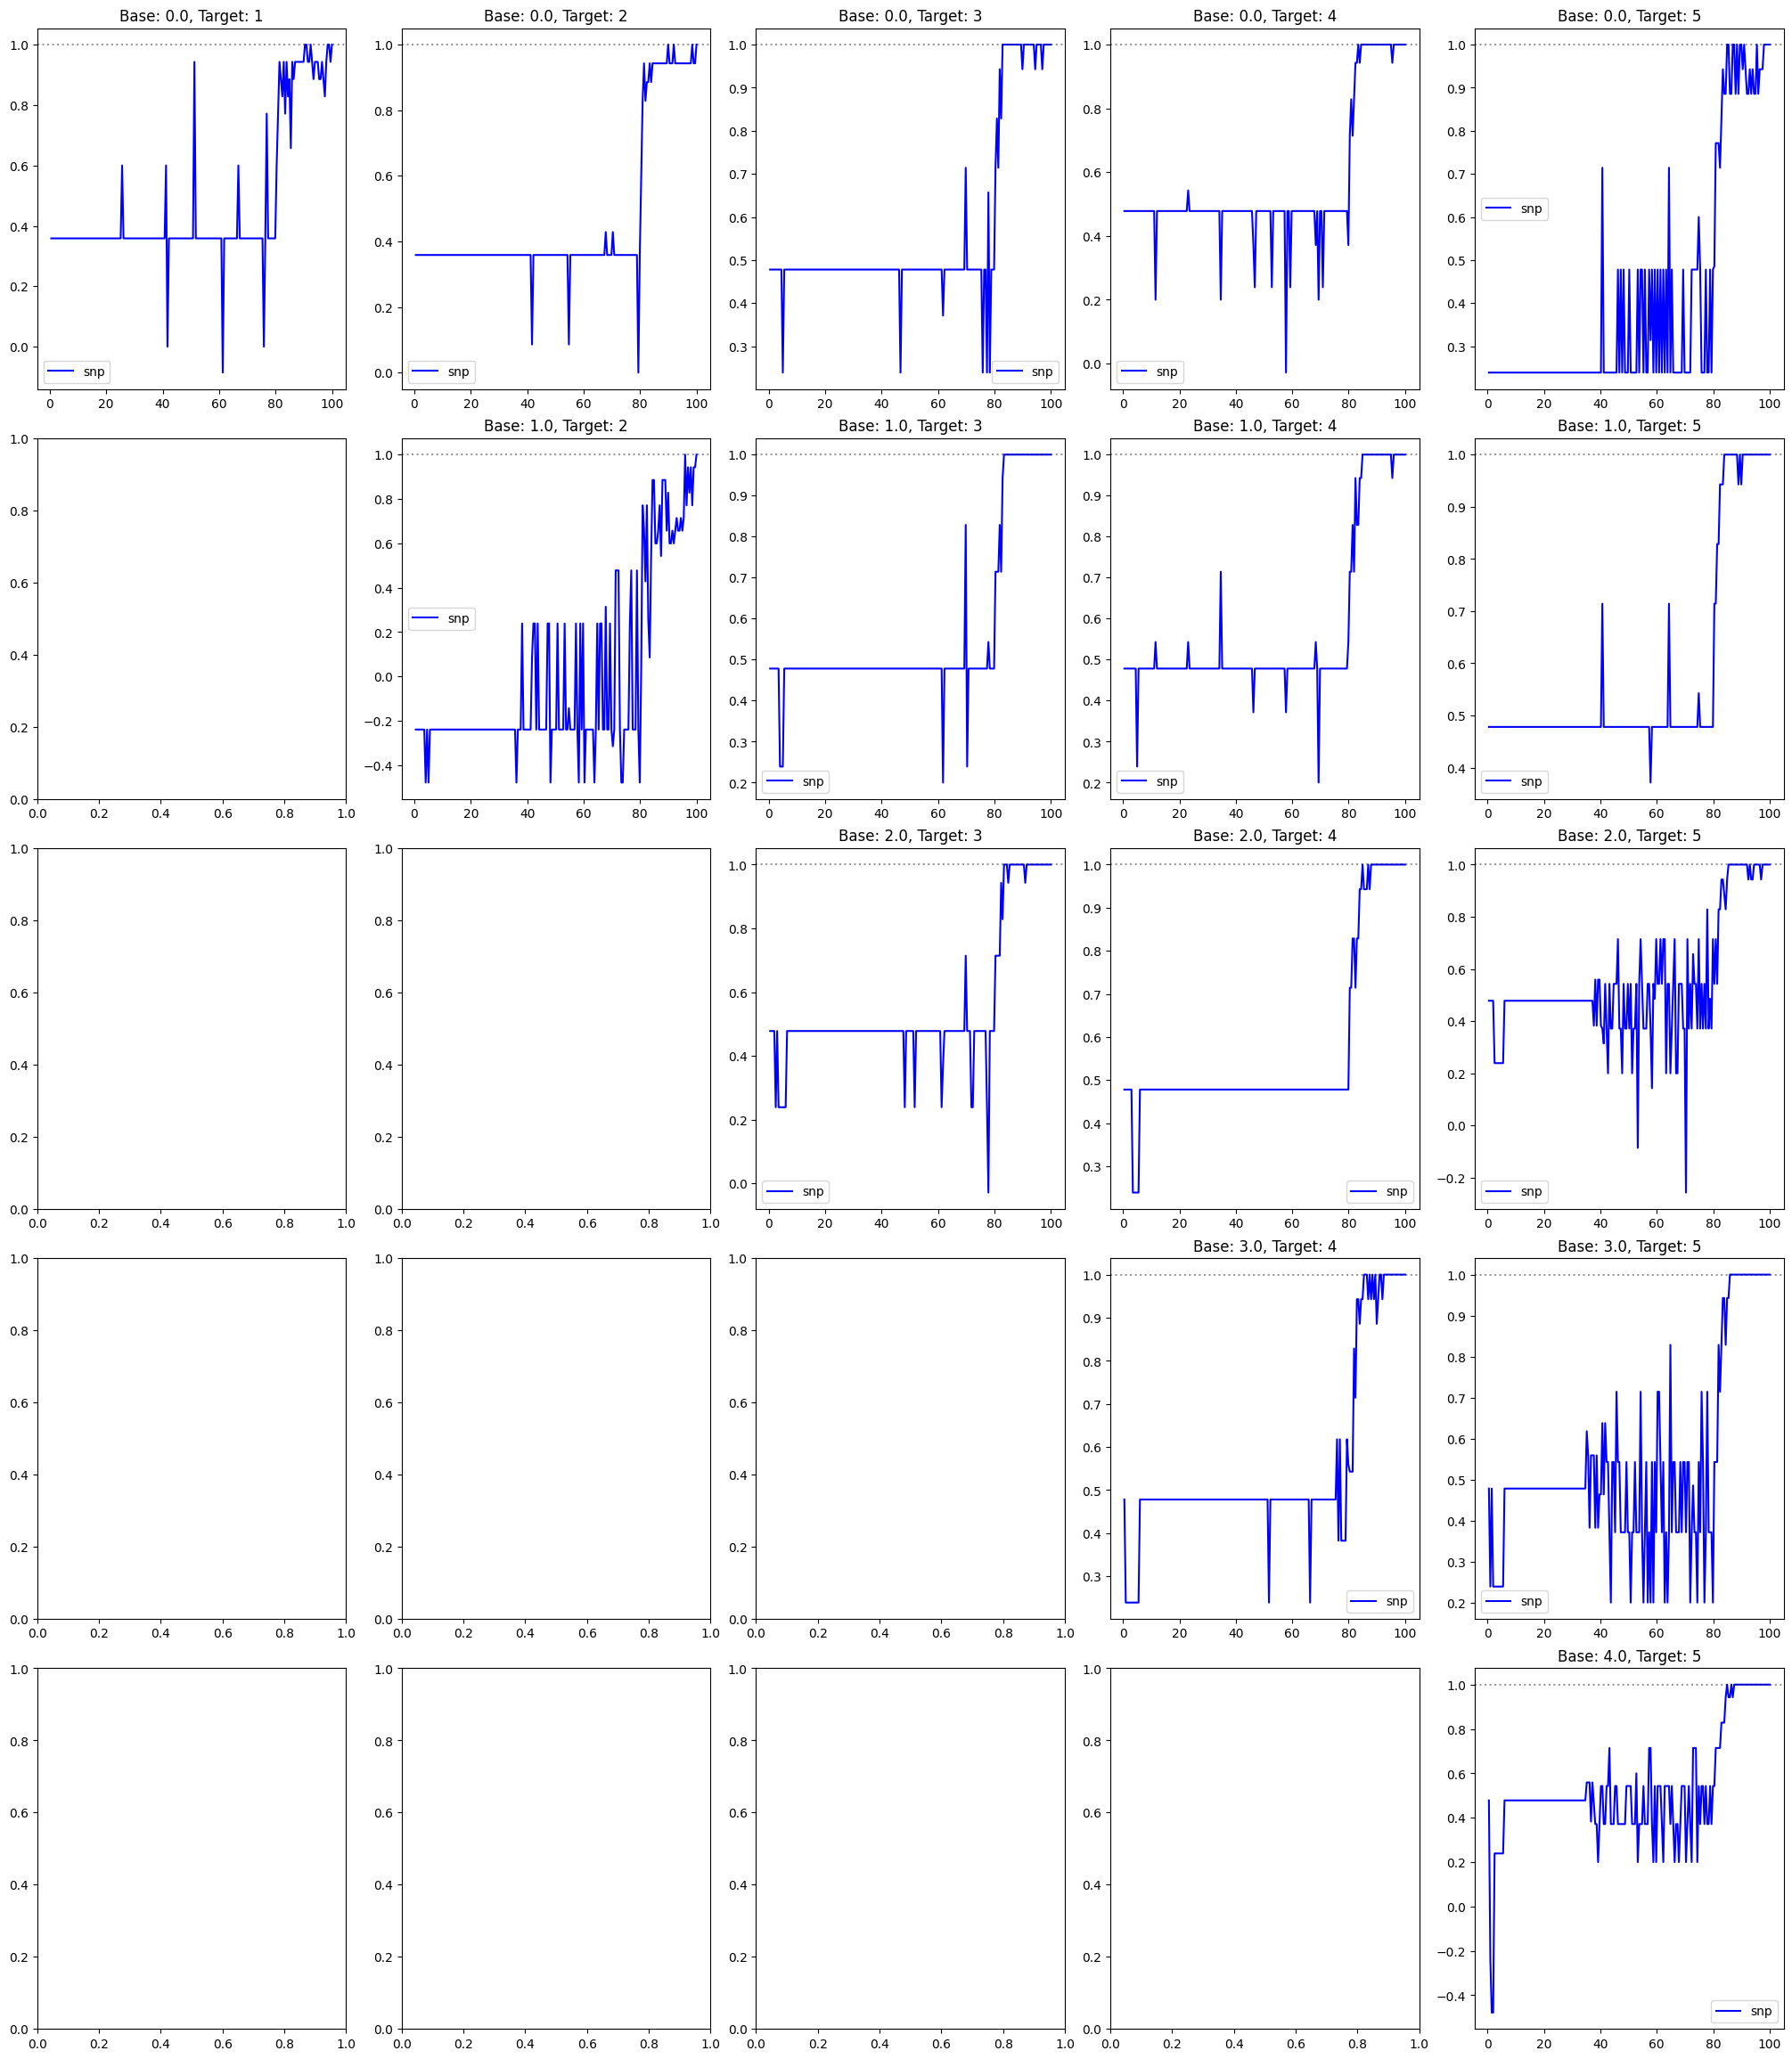

In [10]:
from scipy.stats import spearmanr, kendalltau


def load_and_process_hpo_results(df, x_axis = "percent", correlation_type='spearmanr') -> pd.DataFrame:
    assert x_axis in ['flops', 'percent']
    df = df.copy()
    if correlation_type == 'spearmanr':
        correlation_function = spearmanr
    elif correlation_type == "kendalltau":
        correlation_function = kendalltau
    else:
        raise ValueError(f"Unknown correlation: {correlation_type}")
    
    
    df['max_flops'] = df['curve_flops'].map(lambda x: np.nanmax(x))
    df['min_flops'] = df['curve_flops'].map(lambda x: np.nanmin(x))
    df['curve_percent'] = df['curve_flops'].map(lambda x: x / x.max() * 100)
    
    if x_axis == 'flops':
        intervals = np.linspace(df['min_flops'].max(), df['max_flops'].min(), 200)
    elif x_axis == 'percent':
        intervals = np.linspace(0, 100, 200)[1:]
    else:
        raise ValueError(f"Unknown x_axis: {x_axis}")
    
    df['final_val_loss'] = df['curve_val'].map(lambda x: [x[-1],]*len(intervals))
    
    values = []
    target_values = []
    for row in df.itertuples(index=False):
        _df = pd.DataFrame({
            'val': row.curve_val,
        }, index=row.curve_percent if x_axis == "percent" else row.curve_flops).dropna()
        _df = _df.reindex(_df.index.union(intervals)).sort_index()
        _df['val'] = _df['val'].interpolate(method='linear')
        _df = _df.loc[intervals]
        values.append(_df['val'].values)
        target_values.append(row.final_val_loss)
    values = np.array(values)
    target_values = np.array(target_values)
    
    # apply correlation function column-wise
    correlations = []
    for i in range(values.shape[1]):
        correlations.append(correlation_function(values[:, i], target_values[:, i]).correlation)
    return pd.DataFrame({
        "intervals": intervals,
        "curve_correlation": correlations,
    })

hyperparameter_columns = ['cfg_warmup_fraction', 'cfg_cooldown_fraction']

TKPM = 20.
MIN_FLOPS_SCALE_FACTOR = 8
SCALING = "width"
METHOD = "snp"
mlp_selection_df = mlp_df[mlp_df['tkpm_group']==TKPM]
mlp_selection_df = mlp_selection_df[mlp_selection_df['scaling']==SCALING]
mlp_selection_df_method = mlp_selection_df[mlp_selection_df['method']==METHOD]
mlp_selection_df_mup = mlp_selection_df[mlp_selection_df['method']=='mup']

base_scales = sorted(mlp_selection_df_method['base_scale'].unique())
target_scales = sorted(mlp_selection_df_method['target_scale'].unique())
fig, axes = plt.subplots(len(base_scales), len(target_scales), figsize=(5 * len(target_models), 4.5 * len(base_scales) + 0.5), layout='constrained');

for i, base_scale in enumerate(base_scales):
    for j, target_scale in enumerate(target_scales):
        method_df = mlp_selection_df_method[
            (mlp_selection_df_method['base_scale']==base_scale) &
            (mlp_selection_df_method['target_scale']==target_scale)
        ]
        if len(method_df) != 6:
            continue
        print(f"Base: {base_scale}, Target: {target_scale}, Num Configs: {len(method_df)}")
        hpo_df = load_and_process_hpo_results(method_df)

        axes[i,j].plot(hpo_df['intervals'], hpo_df['curve_correlation'], label=METHOD, color='blue')
        axes[i,j].axhline(y=1, color='black', linestyle=':', alpha=.4)
        
        mup_df = mlp_selection_df_mup[
            (mlp_selection_df_mup['base_scale']==base_scale) &
            (mlp_selection_df_mup['target_scale']==target_scale)
        ]
        if len(mup_df) == 6:
            hpo_mup_df = load_and_process_hpo_results(mup_df)
            axes[i,j].plot(hpo_mup_df['intervals'], hpo_mup_df['curve_correlation'], label='mup', color='red', linestyle='--')
        
        axes[i,j].set_title(f"Base: {base_scale}, Target: {target_scale}")
        axes[i,j].legend()
        

In [8]:
hpo_mup_df

NameError: name 'hpo_mup_df' is not defined

In [7]:
mup_df

,source,scaling,tkpm_group,scale_id,base_scale,target_scale,base_name,base_layers,base_n_embd,base_params_m,...,cfg_cooldown_fraction,x_col,curve_flops,curve_step,curve_tkpp,curve_train,curve_val,base_N,target_N,max_flops
